<br />
<img src="nethone.png" />
<br />

<h1><center>
Bartosz Topolski
<br><br>
21-03-2018
<br><br>
</center></h1>

bartosz.topolski@nethone.com

In [2]:
# automatyczne odświeżanie pakietów importowanych z plików
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd

In [4]:
import xgboost

from transformers import (
    FillNA, 
    SimpleHash, 
    ExtractRegex, 
    HashingTrick
)
from transformers import split_train_test
from pipelines import feature_extraction_subpipeline
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = 300
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('dane_dla_studentow_full.csv')
y = data.pop('cb')
X_train_raw, X_test_raw, y_train, y_test = train_test_split(data, y, train_size=0.75, shuffle=False)

/home/bartek/.virtualenvs/workshop/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


`feature_extraction_subpipeline` zawiera pipeliny wyciągające cechy z danych, ale bez żadnego preprocessingu. 

In [6]:
X_train = feature_extraction_subpipeline.fit_transform(X_train_raw)
X_test = feature_extraction_subpipeline.transform(X_test_raw)

In [7]:
X_train.shape

(21749, 93)

In [8]:
X_train_raw.shape

(21749, 37)

In [9]:
X_train.head(10)

user_ip_country_categorical bin_country_categorical card_type_categorical  \
0                          SE                      SE                 DEBIT   
1                          PH                      PH                CREDIT   
2                          AR                      AR                CREDIT   
3                          AR                      AR                CREDIT   
4                          ZA                      ZA                CREDIT   
5                          BR                      BR                CREDIT   
6                          SA                      SA                CREDIT   
7                          IM                      GB                CREDIT   
8                          BB                      BB                 DEBIT   
9                          PH                      PH                CREDIT   

  card_brand_categorical headers_connection_categorical  \
0                   VISA                     keep-alive   
1                   VISA                     keep-alive   
2             MASTERCARD                     keep-alive   
3                   VISA                     Keep-Alive   
4                   VISA                     keep-alive   
5                   VISA                     keep-alive   
6                   VISA                     keep-alive   
7                   VISA                     Keep-Alive   
8                   VISA                            NaN   
9             MASTERCARD                     keep-alive   

  navigatorappname_categorical navigatorproduct_categorical  \
0                     Netscape                        Gecko   
1                          NaN                          NaN   
2                     Netscape                        Gecko   
3                          NaN                          NaN   
4                     Netscape                        Gecko   
5                          NaN                          NaN   
6                     Netscape                        Gecko   
7                     Netscape                        Gecko   
8                          NaN                          NaN   
9                     Netscape                        Gecko   

  navigatorappcodename_categorical donottrack_categorical  bin_numerical  \
0                          Mozilla                      1         453903   
1                              NaN                    NaN         464995   
2                          Mozilla                unknown         549828   
3                              NaN                    NaN         450979   
4                          Mozilla            unspecified         490136   
5                              NaN                    NaN         493493   
6                          Mozilla                unknown         410684   
7                          Mozilla                unknown         449353   
8                              NaN                    NaN         479468   
9                          Mozilla                unknown         512571   

   headers_content_type_numerical  headers_content_length_numerical  \
0                             NaN                               NaN   
1                             NaN                               NaN   
2                             NaN                               NaN   
3                             NaN                               NaN   
4                             NaN                               NaN   
5                             NaN                               NaN   
6                             NaN                               NaN   
7                             NaN                               NaN   
8                             NaN                               NaN   
9                             NaN                               NaN   

   timeoftotalpageload_numerical  timeofrequestresponse_numerical  \
0                         4665.0                            865.0   
1                            Na

# Detekcja anomalii

Spora ilość cech to dane z profilera podpiętego do przeglądarki, zawierające informacje o urządzeniu z którego korzysta dana osoba. Potencjalnie dobrą cechą byłaby jakaś miara prawdopodobieństwa wystąpienia danego zestawu cech w zbiorze treningowym. W tym celu możemy wykorzystać algorytm detekcji anomalii.

In [14]:
from sklearn.ensemble import IsolationForest

Isolation forest jest algorytmem opartym o drzewa losowe. W przeciwieństwie do Random forestów, podziały są dokonywane losowo, a ich celem jest odizolowanie pojedynczych obserwacji.  
Ogólna zasada działania: na zbiorze treningowym budowanie drzewa polega na wybraniu losowej zmiennej i losowego punktu podziału na niej. Jeśli w danym węźle jest jedna obserwacja, albo osiągnęliśmy maksymalną głębokość drzewa, to nie dokonujemy dalszych podziałów.  
Nową obserwację przepuszczamy przez każde drzewo i liczymy średnią długość ścieżek, które przebyła. Jeżeli jest to anomalia, to spodziewamy się że będzie dochodziła do tych liści drzewa które zawierały pojedynczą obserwację.

<br />
    <img src="img/isoforest.png" />
<br />

In [12]:
from transformers import FillNA, SimpleHash
from pipelines import fingerprint_pipeline, dict_unpack_pipeline

anomaly_pipeline = Pipeline([
    ('All features', dict_unpack_pipeline),
    ('Fill nan', FillNA(-1)),
    ('Hash', SimpleHash())
])

X_train_anomaly = anomaly_pipeline.fit_transform(X_train_raw)
X_test_anomaly = anomaly_pipeline.transform(X_test_raw)

In [15]:
anomaly_detector = IsolationForest(
    n_estimators=200, # ilość drzew w modelu
    max_samples=256, # ilość obserwacji losowanych ze zbioru dla każdego z drzew
    #max_features=2,
    bootstrap=True, # samplowanie - czy ze zwracaniem
    contamination=0.09, # założony z góry odsetek anomalii
    n_jobs=4
)
anomaly_detector.fit(X_train_anomaly)

IsolationForest(bootstrap=True, contamination=0.09, max_features=1.0,
        max_samples=256, n_estimators=200, n_jobs=4, random_state=None,
        verbose=0)

In [16]:
train_anomaly = anomaly_detector.decision_function(X_train_anomaly)
test_anomaly = anomaly_detector.decision_function(X_test_anomaly)
outlier_df = pd.DataFrame({'outlier': test_anomaly, 'cb': y_test})

     outlier          
        mean    median
cb                    
0   0.082555  0.113037
1   0.078242  0.107960


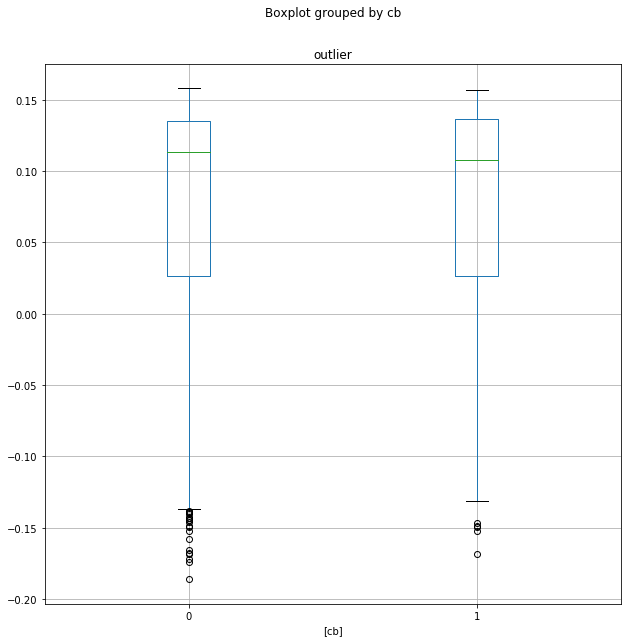

In [17]:
print(outlier_df.groupby('cb').agg([np.mean, np.median]))
outlier_df.boxplot(by='cb', figsize=(10,10))

### Zadanie 1

Na teraz:  
Zastanów się, czy hashowanie kategoryków dobrze współgra z tym algorytmem.   
Napisz transformację, która przyjmie ramkę danych i zwróci kolumnę ze scorem z algorytmu IsolationForest

Do domu:  
Zastosuj algorytm Isolation Forest na innym zestawie kolumn - postaraj znaleźć taki, który w lepszym stopniu wyodrębni chargebacki. Możesz zajrzeć do pliku z pipelinami aby wybrać te, które wydają się mieć największy potencjał. Spróbuj również przefiltrować kolumny pod kątem ilości braków danych - być może utrudniają one wyodrębnienie outlierów.  

# Walidacja modeli

W przeciwienstwie do konkursów Kagglowych, nie mamy wielu prób na przetestowanie modelu ;) Dlatego dużą wagę przywiązujemy do odpowiedniej walidacji modeli - zależy nam na jak najlepszej estymacji zachowania modelu w warunkach produkcyjnych.

#### Metryki:
* accuracy: traci sens przy problemie klas niezbalansowanych (a na ogół tak wygląda sytuacja przy problemie detekcji fraudów),
* AUC ROC: lepsza od accuracy, ale spore znaczenie ma też kształt krzywej, a nie tylko pole pod nią,
* metryki dostosowane pod konkretne problemy

W plikach 'predictions_1.csv' i 'predictions_2.csv' znajdują się przykładowe predykcje pochodzące z dwóch różnych modeli. Oceń jakośc predykcji obu modeli.

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

In [29]:
predictions_1 = pd.read_csv('predictions_1.csv')
predictions_2 = pd.read_csv('predictions_2.csv')

fpr_1, tpr_1, _ = roc_curve(predictions_1['label'], predictions_1['p'])
auc_score_1 = roc_auc_score(predictions_1['label'], predictions_1['p'])

fpr_2, tpr_2, _ = roc_curve(predictions_2['label'], predictions_2['p'])
auc_score_2 = roc_auc_score(predictions_2['label'], predictions_2['p'])

In [30]:
print(auc_score_1)
print(auc_score_2)

0.7119355348545359
0.6856834206715613


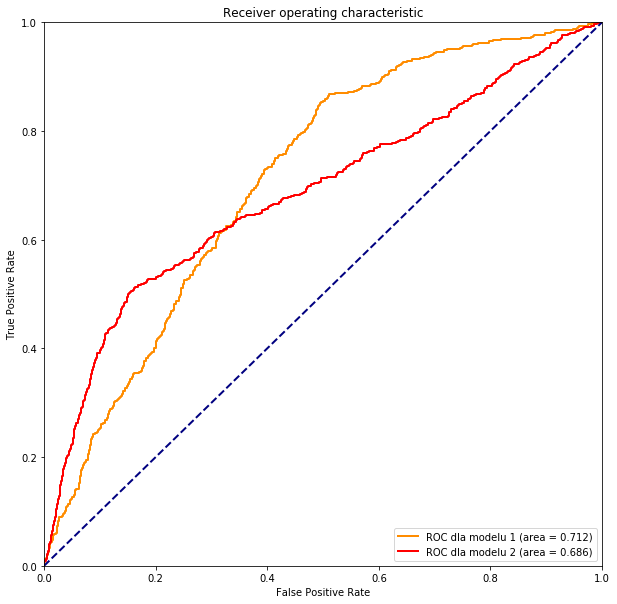

In [31]:
plt.figure(figsize=(10, 10))
lw = 2
plt.plot(fpr_1, tpr_1, color='darkorange', lw=lw, label='ROC dla modelu 1 (area = %0.3f)' % auc_score_1)
plt.plot(fpr_2, tpr_2, color='red', lw=lw, label='ROC dla modelu 2 (area = %0.3f)' % auc_score_2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
def threshold_recall(threshold, y_true, y_pred):
    assert 0 <= threshold <= 1

    df = pd.DataFrame(dict(y_true=y_true, y_pred=y_pred))
    df = df.sort_values(by=['y_pred'], ascending=False)

    split_index = int(threshold * df.shape[0])
    
    true_positive_count = df.iloc[:split_index]['y_true'].sum()
    all_true = df['y_true'].sum()

    return float(true_positive_count) / all_true

In [33]:
print("Recall przy progu odcięcia %s dla modelu 1: %s" % (
    str(0.2), threshold_recall(0.2, predictions_1['label'], predictions_1['p'])
))
print("Recall przy progu odcięcia %s dla modelu 2: %s" % (
    str(0.2), threshold_recall(0.2, predictions_2['label'], predictions_2['p'])
))

Recall przy progu odcięcia 0.2 dla modelu 1: 0.3651452282157676
Recall przy progu odcięcia 0.2 dla modelu 2: 0.5060728744939271


### Walidacja  krzyżowa

Chcąc uzyskać dobre oszacowanie zachowania modelu w warunkach produkcyjnych, nie możemy korzystać z walidacji krzyżowej - przy losowym doborze obserwacji do danych treningowych i testowych zakładamy niejawnie, że przy uczeniu modelu mamy dostępne również informacje z przyszłości. Rozwiązaniem jest `TimeSeriesSplit` z pakietu `scikit-learn`.

In [34]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [35]:
example_data = pd.DataFrame({'x': range(20)})
data_generator = TimeSeriesSplit(4).split(example_data)

In [36]:
for train_id, val_id in data_generator:
    print(train_id, val_id)

(array([0, 1, 2, 3]), array([4, 5, 6, 7]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 8,  9, 10, 11]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([12, 13, 14, 15]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]), array([16, 17, 18, 19]))


Łatwo zauważyć, że ta metoda jest obarczona większą wariancją niż klasyczna kroswalidacja - dla pierwszych splitów uczymy nasz model na bardzo małych próbkach.

In [37]:
def validate_model(model, X, y, num_splits=4, threshold=0.2):
    """
    Funkcja walidująca podany model na zbiorze X,y. Zwraca słownik zawierający średnie AUC oraz średni recall.
    """
    train_data_generator = TimeSeriesSplit(num_splits).split(X_train)
    aucs = []
    recalls = []
    for train_indices, validation_indices in train_data_generator:
        X_train_cv = X.iloc[train_indices,:]
        y_train_cv = y.iloc[train_indices]
        X_valid_cv = X.iloc[validation_indices,:]
        y_valid_cv = y.iloc[validation_indices]
        model.fit(X_train_cv, y_train_cv)
        predictions = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_score=predictions, y_true=y_valid_cv)
        recall = threshold_recall(threshold, y_pred=predictions, y_true=y_valid_cv)
        aucs.append(auc)
        recalls.append(recall)
    return {
        'auc': np.mean(aucs),
        'recall': np.mean(recalls)
    }
    

## Zadanie 2.

Do testowania kolejnych algorytmów będziemy potrzebowali jakiegoś punktu wyjścia. Naucz wybrany model z pakietu `scikit-learn` (na przykład RandomForest) na naszych danych. Możesz użyć danych obrobionych przez `feature_extraction_subpipeline`, możesz też wprowadzić swoje modyfikacje (przykładowo, użycie feature selection). Sprawdź, na ile wynik z walidacji pokrywa się z testowym.

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
prepare_for_model_pipe = Pipeline([
    ('Fill nan', FillNA(-1)),
    ('Hash', SimpleHash())
])


X_train_prepared = prepare_for_model_pipe.fit_transform(X_train)
X_test_prepared = prepare_for_model_pipe.fit_transform(X_test)

In [40]:
model = RandomForestClassifier()

In [41]:
validation_result = validate_model(model, X_train_prepared, y_train)

In [42]:
print(validation_result)

{'recall': 0.24520568738617363, 'auc': 0.5441526563141088}


# Gradient Boosting Machines

Dlaczego drzewa decyzyjne (i algorytmy o nie oparte)?
* nie wymagają założeń o rozkładach zmiennych
* prosta obsługa kolumn kategorycznych
* wydajne (w sensie jakości modelu)
* wydajne (w sensie szybkości)

Dlaczego nie?
* tzw. 'black-box' - mamy narzędzie które dokonuje predykcji, ale nie jesteśmy w stanie jasno określić co przyczyniło się do tej predykcji.

Alternatywa dla kiedyś popularnych lasów losowych. Najważniejszą zmianą jest sposób budowania drzew. W skrócie - każde kolejne drzewo jest budowane w oparciu o błędy poprzednich.  
W najprostszym wariancie schemat można opisać następująco:  
1. Dopasuj model $F_0(x)$ do wartości $y$.  
2. W i-tym kroku:  
    * oblicz błędy $d_i(x) = y - F_{i-1}(x)$,  
    * dopasuj model $h_i(x)$ do błędów $d_i(x)$,
    * $F_i(X) = F_{i-1}(x) + h_i(x)$.
    
Zainteresowanym polecam wizualizację: https://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html

Obecnie najpopularniejszą implementacją jest pakiet `xgboost` oraz `lightgbm`. Wprowadza zmiany w samym algorytmie boostingu, jak i w implementacji sposobu budowania drzew.  

Schemat działania XGBoosta opiera się o minimalizację zadanej funkcji straty $\mathcal{L}(y, \hat{y})$.  
W i-tym kroku staramy się dołożyć takie drzewo $h_i(X)$, aby zminimalizować $\mathcal{L}(y, F_{i-1}(x) + h_i(x))$.  
W celu optymalizacji tego wyrażenia względem $h_i(x)$ korzysta się z częściowego rozwinięcia funkcji $\mathcal{L}$ w szereg Taylora:  
$$\mathcal{L}(y, F_{i-1}(x) + h_i(x)) = \mathcal{L}(y, F_{i-1}(x)) + g_i h_i(x) + \frac{1}{2}h_i h^2_i(x)$$
gdzie $g_i$ i $h_i$ to odpowiednio pierwsza i druga pochodna $\mathcal{L}(y, F_{i-1}(x))$ po $F_{i-1}(x)$.

Takie podejście pozwala zastosować ten algorytm do dowolnego problemu w którym musimy zminimalizować jakąś funkcję straty - to, co musimy podać na wejściu to zadana przez nas funkcja oraz jej pierwsza i druga pochodna.

Dodatkowo, XGBoost oferuje duże możliwości regularyzacji modelu - najważniejszą jest tzw. *shrinkage* - czyli skalowanie wag każdego drzewa przez pewną stałą wartość. Dzięki temu możemy zmniejszyć wpływ pojedynczego drzewa na model, co prowadzi do potencjalnie mniej przeuczonego modelu.

In [65]:
from xgboost import XGBClassifier, plot_importance

In [46]:
from lightgbm import LGBMClassifier, plot_importance

In [57]:
estimator_xgb = XGBClassifier(
    max_depth=6, # maksymalna głebokość drzewa
    learning_rate=0.1, # parametr kontrolujący shrinkage
    n_estimators=100, # ilość drzew
    gamma=0, # dolne ograniczenie na zmniejszenie funkcji straty przy podziale
    min_child_weight=1, # ograniczenie na minimalną ilość obserwacji w liściu (realizowane poprzez łączną sumę h_i w danym liściu)
    max_delta_step=0, # górne ograniczenie na wielkość wagi w drzewie
    subsample=1, 
    colsample_bytree=1, 
    reg_alpha=0, 
    reg_lambda=1, 
    missing=-1
)

In [47]:
estimator_xgb = LGBMClassifier()

In [58]:
validate_model(estimator_xgb, X_train_prepared, y_train)

{'auc': 0.6100634418802167, 'recall': 0.31678603710233333}

In [59]:
estimator_xgb.fit(X_train_prepared, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=-1, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [60]:
y_pred = estimator_xgb.predict_proba(X_test_prepared)[:, 1]
print(threshold_recall(0.2, y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

0.395555555556
0.6659045204900719


In [61]:
y_pred_train = estimator_xgb.predict_proba(X_train_prepared)[:, 1]
print(threshold_recall(0.2, y_train, y_pred_train))
print(roc_auc_score(y_train, y_pred_train))

0.783757338552
0.9117086492496218


#### Wykresy istotności cech
Dla xgboosta mamy dostępne trzy rodzaje istotności:
* weight - ile razy cecha pojawia się w splicie
* gain - uśredniony wkład w odpowiedź
* cover - pokrycie zbioru treningowego przez splity po danej kolumnie



In [63]:
type(estimator_xgb)

xgboost.sklearn.XGBClassifier

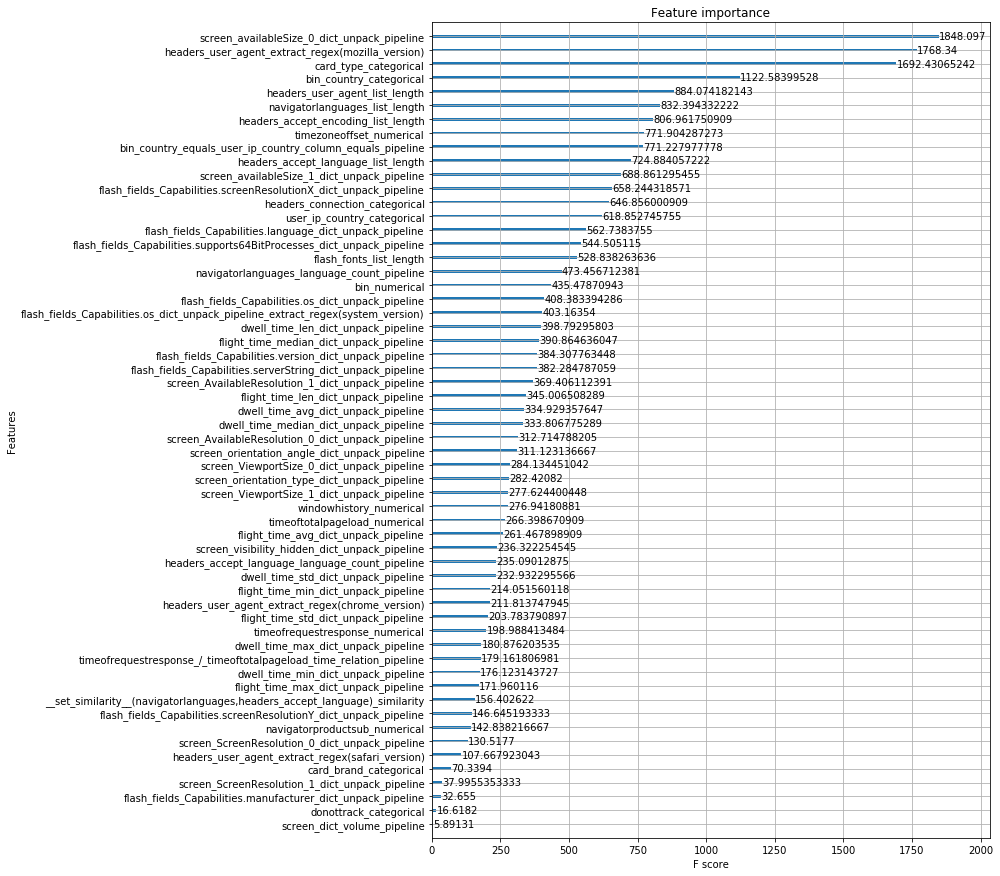

In [69]:
ax = plot_importance(estimator_xgb, importance_type='cover')
fig = ax.figure
fig.set_size_inches(10, 15)
plt.show()

Dlaczego warto zwracać na to uwagę?  
* spojrzenie na cechy istotne dla modelu często pozwala stwierdzić, że model jest przeuczony (na przykład na kolumnie niewprost indentyfikującej konkretnego użytkownika)
* często zdarzają się cechy, które potencjalni fraudsterzy mogliby łatwo zmienić konkretnymi zachowaniami - nie chcielibyśmy, aby to były główne przyczyny podejmowania decyzji przez model
* mogą się zdarzyć również sytuacje, w których używanie pewnej cechy przez model jest w jakimś stopniu niepożądane przez klienta

### Zadanie 3

Zbadaj wpływ parametrów modelu na jego wyniki. Oczywiście najbardziej interesuje nas wydajność na zbiorze testowym, ale warto też mieć pod kontrolą wyniki na zbiorze treningowym oraz istotność cech.

## 'Dlaczego moja transakcja nie przeszła?' - Explain it Like I'm 5 (ELI5)

Spróbujemy teraz poradzić sobie jakoś z 'czarnoskrzynkowością' naszego modelu. Wiemy już jak wydobywać informacje o tym, które cechy były brane pod uwagę przy uczeniu modelu. Nie pozwala nam to jednak stwierdzić co wpłynęło na daną decyzję dla konkretnej obserwacji. Z pomocą przychodzi nam pakiet `eli5`.

`eli5` udostępnia nam dwie funkcjonalności: wyjaśnienie wag modelu, oraz objaśnienie predykcji dla konkretnej obserwacji. Głównym targetem pakietu są modele dostępne w module `sklearn`, ale na szczęście twórcy pomyśleli też o obsłudze XGBoosta.  
`explain_weights_xgboost` jest tak naprawdę ładnym opakowaniem na istotność cech z poprzedniej sekcji.  
`explain_prediction_xgboost` dokonuje predykcji na jednej obserwacji, i na podstawie ścieżek w drzewie odwiedzanych podczas predykcji wyznacza łączny wpływ danej cechy na predykcję.

`LIME`

In [70]:
from eli5 import explain_prediction_xgboost, explain_weights_xgboost

In [71]:
from eli5 import explain_prediction_lightgbm, explain_weights_lightgbm

In [72]:
explain_weights_xgboost(estimator_xgb._Booster)

Explanation(estimator='<xgboost.core.Booster object at 0x7f739f4f1d90>', description='\nXGBoost feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=None, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature=u'bin_country_categorical', weight=0.030398017, std=None, value=None), FeatureWeight(feature=u'card_type_categorical', weight=0.028961092, std=None, value=None), FeatureWeight(feature=u'user_ip_country_categorical', weight=0.025359878, std=None, value=None), FeatureWeight(feature=u'headers_accept_language_language_count_pipeline', weight=0.02370798, std=None, value=None), FeatureWeight(feature=u'donottrack_categorical', weight=0.022373527, std=None, value=None), FeatureWeight(feature=u'flash_fields_Capabilities.manufacturer_dict_unpack_pipeline', weight=0.021419888, std=None, value=None), FeatureWeight(feature=u'bin_numerical', weight=0.021269953, std=None, value=None), FeatureWeight(feature=u'screen_orientation_angle_dict_unpack_pipeline', weight=0.021096453, std=None, value=None), FeatureWeight(feature=u'screen_ScreenResolution_0_dict_unpack_pipeline', weight=0.020909144, std=None, value=None), FeatureWeight(feature=u'screen_availableSize_1_dict_unpack_pipeline', weight=0.020279253, std=None, value=None), FeatureWeight(feature=u'screen_AvailableResolution_1_dict_unpack_pipeline', weight=0.020218687, std=None, value=None), FeatureWeight(feature=u'timezoneoffset_numerical', weight=0.019919952, std=None, value=None), FeatureWeight(feature=u'dwell_time_std_dict_unpack_pipeline', weight=0.019500496, std=None, value=None), FeatureWeight(feature=u'headers_accept_language_list_length', weight=0.019210912, std=None, value=None), FeatureWeight(feature=u'dwell_time_len_dict_unpack_pipeline', weight=0.018506173, std=None, value=None), FeatureWeight(feature=u'windowhistory_numerical', weight=0.018407669, std=None, value=None), FeatureWeight(feature=u'flight_time_min_dict_unpack_pipeline', weight=0.01837914, std=None, value=None), FeatureWeight(feature=u'screen_orientation_type_dict_unpack_pipeline', weight=0.018286465, std=None, value=None), FeatureWeight(feature=u'dwell_time_avg_dict_unpack_pipeline', weight=0.01826319, std=None, value=None), FeatureWeight(feature=u'screen_dict_volume_pipeline', weight=0.018223198, std=None, value=None)], remaining=73), decision_tree=None, highlight_spaces=None, transition_features=None)

In [74]:
example_fraud = X_test_prepared[y_test == 1].iloc[10]

explain_prediction_xgboost(estimator_xgb._Booster, example_fraud)

Explanation(estimator='<xgboost.core.Booster object at 0x7f739f4f1d90>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='card_type_categorical', weight=0.1888724779243574, std=None, value=32900.0), FeatureWeight(feature='bin_country_categorical', weight=0.18312293875492042, std=None, value=97720.0), FeatureWeight(feature='dwell_time_median_dict_unpack_pipeline', weight=0.18259034774665045, std=None, value=127.0), FeatureWeight(feature='user_ip_country_categorical', weight=0.14677424731139396, std=None, value=97720.0), FeatureWeight(feature='flash_fields_Capabilities.language_dict_unpack_pipeline', weight=0.13730385716981722, std=None, value=-1.0), FeatureWeight(feature='flight_time_median_dict_unpack_pipeline', weight=0.127363935217208, std=None, value=552.0050000000047), FeatureWeight(feature='dwell_time_min_dict_unpack_pipeline', weight=0.0961324051545643, std=None, value=75.00500000000466), FeatureWeight(feature='timeofrequestresponse_/_timeoftotalpageload_time_relation_pipeline', weight=0.09484760029051503, std=None, value=0.20399680255795363), FeatureWeight(feature='timeoftotalpageload_numerical', weight=0.07642770978565953, std=None, value=6255.0), FeatureWeight(feature='flash_fields_Capabilities.serverString_dict_unpack_pipeline', weight=0.06856538241274335, std=None, value=-1.0), FeatureWeight(feature='windowhistory_numerical', weight=0.0638276864658772, std=None, value=7.0), FeatureWeight(feature='headers_user_agent_extract_regex(chrome_version)', weight=0.04596242036289303, std=None, value=55.0), FeatureWeight(feature='flight_time_avg_dict_unpack_pipeline', weight=0.035455527122498526, std=None, value=580.0002173913109), FeatureWeight(feature='headers_accept_language_language_count_pipeline', weight=0.0345490411518919, std=None, value=1.0), FeatureWeight(feature='flight_time_max_dict_unpack_pipeline', weight=0.01999458385892701, std=None, value=991.9999999999709), FeatureWeight(feature='dwell_time_avg_dict_unpack_pipeline', weight=0.0196739901415481, std=None, value=125.48635135134887), FeatureWeight(feature='headers_accept_encoding_list_length', weight=0.019091636907592816, std=None, value=4.0), FeatureWeight(feature='flash_fields_Capabilities.supports64BitProcesses_dict_unpack_pipeline', weight=0.018928848758780058, std=None, value=-1.0), FeatureWeight(feature='navigatorlanguages_language_count_pipeline', weight=0.013579262256574314, std=None, value=1.0), FeatureWeight(feature='headers_user_agent_list_length', weight=0.012533113526286204, std=None, value=3.0), FeatureWeight(feature='screen_availableSize_1_dict_unpack_pipeline', weight=0.010296406167223672, std=None, value=0.0), FeatureWeight(feature='dwell_time_std_dict_unpack_pipeline', weight=0.00898818617715736, std=None, value=24.094823001445675), FeatureWeight(featur